# Data Loading & Graph Construction

This notebook loads the Elliptic Bitcoin transaction dataset and constructs a PyTorch Geometric graph.

## Overview
1. Import libraries and set random seeds
2. Load transaction features
3. Load and map labels (illicit/licit/unknown)
4. Load edges and create undirected graph
5. Build PyTorch Geometric Data object
6. Save graph and visualize data distribution

**Estimated time:** 5-10 minutes

In [11]:
# Clear any cached src imports
import sys
if 'src' in sys.modules:
    del sys.modules['src']
if 'src.config' in sys.modules:
    del sys.modules['src.config']
if 'src.utils' in sys.modules:
    del sys.modules['src.utils']
print("✓ Cleared cached imports")

✓ Cleared cached imports


In [12]:
import sys
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import os

# Add project root to sys.path
notebook_dir = os.path.abspath('')
project_root = os.path.dirname(notebook_dir)
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.config import DATASET_CONFIG, TRAINING_CONFIG, DATA_DIR, ARTIFACTS_DIR, FIGURES_DIR, ARTIFACT_FILES, FIGURE_FILES
from src.utils import set_random_seeds

# Set random seeds for reproducibility
set_random_seeds(TRAINING_CONFIG['random_seed'])

## 1. Import Libraries & Initialize

Import required packages and set random seeds for reproducibility.

In [13]:
print("Loading features...")
features_file = DATA_DIR / DATASET_CONFIG['features_file']
df_features = pd.read_csv(features_file, header=0)  # Skip header row
print(f"Shape: {df_features.shape}")

node_ids = df_features.iloc[:, 0].values
timesteps = df_features.iloc[:, 1].values
features = df_features.iloc[:, 2:].values.astype(np.float32)

node_id_to_idx = {nid: idx for idx, nid in enumerate(node_ids)}
print(f"Nodes: {len(node_ids)}, Features: {features.shape[1]}")

Loading features...
Shape: (203769, 184)
Nodes: 203769, Features: 182


## 2. Load Transaction Features

Load node features from CSV. Each row represents a transaction with:
- Column 0: Transaction ID
- Column 1: Timestep
- Columns 2+: Feature vector

In [14]:
print("Loading labels...")
classes_file = DATA_DIR / DATASET_CONFIG['classes_file']
df_classes = pd.read_csv(classes_file)
print("Original class distribution:")
print(df_classes[DATASET_CONFIG['label_column']].value_counts())

labels = np.full(len(node_ids), -1, dtype=np.int64)

illicit_label = DATASET_CONFIG['illicit_label']
licit_label = DATASET_CONFIG['licit_label']

for _, row in tqdm(df_classes.iterrows(), total=len(df_classes), desc="Processing labels"):
    node_id = row[DATASET_CONFIG['id_column']]
    if node_id in node_id_to_idx:
        idx = node_id_to_idx[node_id]
        if row[DATASET_CONFIG['label_column']] == illicit_label:
            labels[idx] = 1  # Illicit
        elif row[DATASET_CONFIG['label_column']] == licit_label:
            labels[idx] = 0  # Licit
        # Unknown (3) remains -1

labeled_mask = labels != -1
print(f"\nLabeled: {labeled_mask.sum()}, Unlabeled: {(~labeled_mask).sum()}")
print(f"Licit (0): {(labels==0).sum()}, Illicit (1): {(labels==1).sum()}")

Loading labels...
Original class distribution:
class
3    157205
2     42019
1      4545
Name: count, dtype: int64


Processing labels: 100%|██████████| 203769/203769 [00:01<00:00, 103411.85it/s]


Labeled: 46564, Unlabeled: 157205
Licit (0): 42019, Illicit (1): 4545


## 3. Load and Map Labels

Load transaction labels and map to binary classification:
- **Class 1** → Label 1 (Illicit)
- **Class 2** → Label 0 (Licit)
- **Class 3** → Label -1 (Unknown/Unlabeled)

In [15]:
print("Loading edges...")
edgelist_file = DATA_DIR / DATASET_CONFIG['edgelist_file']
df_edges = pd.read_csv(edgelist_file)
print(f"Edges in file: {len(df_edges)}")

edge_list = []
for _, row in tqdm(df_edges.iterrows(), total=len(df_edges), desc="Processing edges"):
    src_id = row[DATASET_CONFIG['edge_source_column']]
    dst_id = row[DATASET_CONFIG['edge_target_column']]
    
    if src_id in node_id_to_idx and dst_id in node_id_to_idx:
        src_idx = node_id_to_idx[src_id]
        dst_idx = node_id_to_idx[dst_id]
        edge_list.append([src_idx, dst_idx])
        edge_list.append([dst_idx, src_idx])  # Make undirected

edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
print(f"Edge index shape (before self-loops): {edge_index.shape}")

# Add self-loops for GAT
edge_index, _ = add_self_loops(edge_index, num_nodes=len(node_ids))
print(f"Edge index shape (after self-loops): {edge_index.shape}")

Loading edges...
Edges in file: 234355


Processing edges: 100%|██████████| 234355/234355 [00:02<00:00, 96868.65it/s] 

Edge index shape (before self-loops): torch.Size([2, 468710])
Edge index shape (after self-loops): torch.Size([2, 672479])


## 4. Load Edges & Create Graph

Load transaction edges and create undirected graph by adding reverse edges.
Self-loops are added for better GAT performance.

In [16]:
x = torch.tensor(features, dtype=torch.float32)
y = torch.tensor(labels, dtype=torch.long)
timestep_tensor = torch.tensor(timesteps, dtype=torch.long)
labeled_mask_tensor = torch.tensor(labeled_mask, dtype=torch.bool)
unlabeled_mask_tensor = torch.tensor(~labeled_mask, dtype=torch.bool)

data = Data(
    x=x,
    edge_index=edge_index,
    y=y,
    timestep=timestep_tensor,
    labeled_mask=labeled_mask_tensor,
    unlabeled_mask=unlabeled_mask_tensor
)

print(data)


Data(x=[203769, 182], edge_index=[2, 672479], y=[203769], timestep=[203769], labeled_mask=[203769], unlabeled_mask=[203769])


## 5. Create PyTorch Geometric Data Object

Bundle all graph components into a single Data object with:
- Node features (x)
- Edge indices
- Labels (y)
- Timesteps
- Labeled/unlabeled masks

In [17]:
save_path = ARTIFACTS_DIR / ARTIFACT_FILES['baseline_graph']
torch.save(data, save_path)
print(f"Graph saved to {save_path}")

Graph saved to C:\Users\tusha\Documents\UT_Dallas\ACM_SP26\Kryptos---Quantum-Blockchain-Fraud-Detection\artifacts\elliptic_graph.pt


## 6. Save Graph to Disk

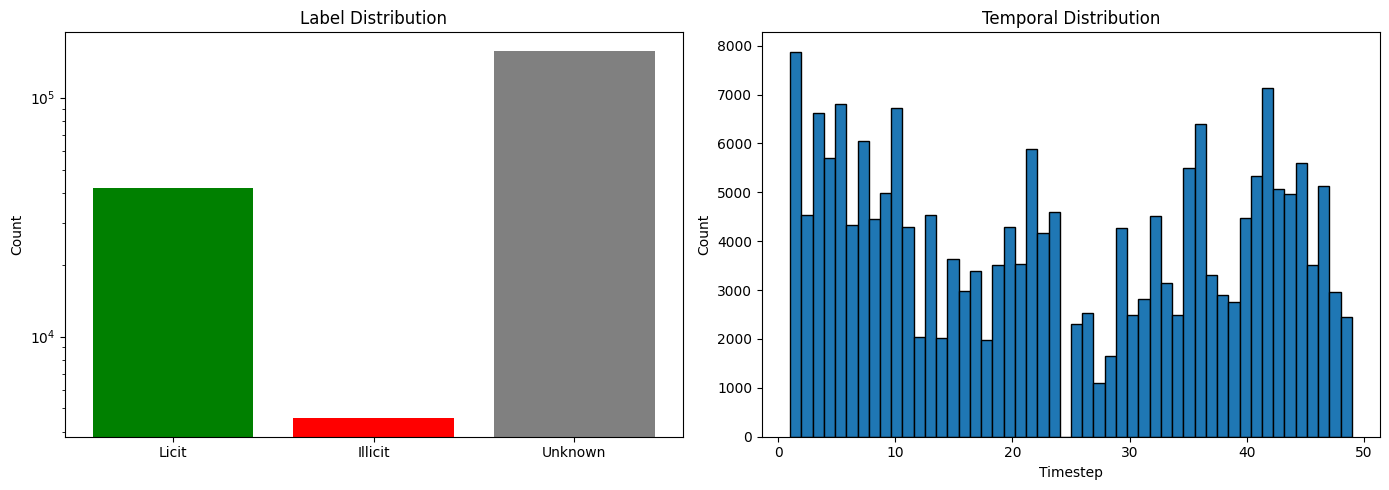

Done! Proceed to 03_train_gat_baseline.ipynb


In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Labels
label_counts = [(labels==0).sum(), (labels==1).sum(), (~labeled_mask).sum()]
axes[0].bar(['Licit', 'Illicit', 'Unknown'], label_counts, color=['green', 'red', 'gray'])
axes[0].set_ylabel('Count')
axes[0].set_title('Label Distribution')
axes[0].set_yscale('log')

# Timesteps
axes[1].hist(timesteps, bins=50, edgecolor='black')
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Count')
axes[1].set_title('Temporal Distribution')

plt.tight_layout()
save_path = FIGURES_DIR / FIGURE_FILES['data_distribution']
plt.savefig(save_path, dpi=150)
plt.show()

print("Done! Proceed to 03_train_gat_baseline.ipynb")

---

## ✅ Graph Construction Complete!

The transaction graph has been built and saved. Proceed to **03_train_gat_baseline.ipynb** to train the baseline GAT model.

## 7. Visualize Data Distribution

Plot label distribution and temporal characteristics of the dataset.